In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import cell_tree2d
import xmitgcm
import xgcm
import numpy as np

In [112]:
llc90_extra_metadata = xmitgcm.utils.get_extra_metadata(domain='llc', nx=90)
grid = xmitgcm.utils.get_grid_from_input('/swot/SUM01/spencer/ECCO_diags/tile<NFACET>.mitgrid',
                                         geometry='llc',
                                         extra_metadata=llc90_extra_metadata)
blankList=[1,2,3,5,6,28,29,30,31,32,33,49,50,52,53,72,81,90,99,108,117]
#note that the blank list is given starting at 1. We will not alter this, so that people
#can just copy the input

In [113]:
llc90_extra_metadata

{'has_faces': True,
 'ny': 1170,
 'nx': 90,
 'ny_facets': [270, 270, 90, 270, 270],
 'face_facets': [0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 4, 4, 4],
 'facet_orders': ['C', 'C', 'C', 'F', 'F'],
 'face_offsets': [0, 1, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2],
 'transpose_face': [False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  True,
  True,
  True,
  True,
  True]}

In [265]:
from dask.base import tokenize
import dask.array as dsa
from functools import reduce
import os
import xarray as xr


def get_xg_yg_from_input(gridfile, nx=None, ny=None, geometry='llc',
                        dtype=np.dtype('d'), endian='>', use_dask=False,
                        extra_metadata=None, tilex=30, tiley=30):
    """ 
    Read grid variables from grid input files, this is especially useful
    for llc and cube sphere configurations used with land tiles
    elimination. Reading the input grid files (e.g. tile00[1-5].mitgrid)
    allows to fill in the blanks of eliminated land tiles.
    PARAMETERS
    ----------
    gridfile : str
        gridfile must contain <NFACET> as wildcard (e.g. tile<NFACET>.mitgrid)
    nx : int
        size of the face in the x direction
    ny : int
        size of the face in the y direction
    geometry : str
        domain geometry can be llc, cs or carthesian not supported yet
    dtype : np.dtype
        numeric precision (single/double) of input data
    endian : string
        endianness of input data
    use_dask : bool
        use dask or not
    extra_metadata : dict
        dictionary of extra metadata, needed for llc configurations
    RETURNS
    ------- 
    grid : xarray.Dataset
        all grid variables
    """

    file_metadata = {}
    # grid variables are stored in this order
    file_metadata['fldList'] = ['XC', 'YC', 'DXF', 'DYF', 'RAC',
                                'XG', 'YG', 'DXV', 'DYU', 'RAZ',
                                'DXC', 'DYC', 'RAW', 'RAS', 'DXG', 'DYG']

    file_metadata['vars'] = file_metadata['fldList']
    dims_vars_list = []
    for var in file_metadata['fldList']:
        dims_vars_list.append(('ny', 'nx'))
    file_metadata['dims_vars'] = dims_vars_list

    # no vertical levels or time records
    file_metadata['nz'] = 1
    file_metadata['nt'] = 1

# for curvilinear non-facet grids (TO DO)
#    if nx is not None:
#        file_metadata['nx'] = nx
#    if ny is not None:
#        file_metadata['ny'] = ny
    if extra_metadata is not None:
        file_metadata.update(extra_metadata)

    # numeric representation
    file_metadata['endian'] = endian
    file_metadata['dtype'] = dtype

    if geometry == 'llc':
        nfacets = 5
        try:
            nfaces = len(file_metadata['face_facets'])
        except:
            raise ValueError('metadata must contain face_facets')
    if geometry == 'cs':  # pragma: no cover
        raise NotImplementedError("'cs' geometry is not supported yet")

    # create placeholders for data
    gridfields = {}
    for field in ['XG', 'YG']:#
        gridfields.update({field: None})

    if geometry == 'llc':
        tileno=0
        dummy=0
        for kfacet in range(nfacets):
            # we need to adapt the metadata to the grid file
            grid_metadata = file_metadata.copy()

            fname = gridfile.replace('<NFACET>', str(kfacet+1).zfill(3))
            grid_metadata['filename'] = fname

            if file_metadata['facet_orders'][kfacet] == 'C':
                nxgrid = file_metadata['nx'] + 1
                nygrid = file_metadata['ny_facets'][kfacet] + 1
            elif file_metadata['facet_orders'][kfacet] == 'F':
                nxgrid = file_metadata['ny_facets'][kfacet] + 1
                nygrid = file_metadata['nx'] + 1

            grid_metadata.update({'nx': nxgrid, 'ny': nygrid,
                                  'has_faces': False})

            raw = read_all_variables(grid_metadata['vars'], grid_metadata,
                                     use_dask=use_dask)

            rawfields = {}
            for kfield in np.arange(len(file_metadata['fldList'])):

                rawfields.update(
                    {file_metadata['fldList'][kfield]: raw[kfield]})
                
            tiles_on_facet=(nxgrid-1)*(nygrid-1)//tilex//tiley
            tile_in_x=(nxgrid-1)//tilex
            tile_in_y=(nygrid-1)//tiley

            for field in ['XG', 'YG']:
                if field =='XG':
                    save_tile=tileno
                else:
                    tileno=save_tile
                    if kfacet == 0:
                        dummy=0
                # symetrize
                tmp = rawfields[field][:, :, :, :].squeeze()
                # transpose
                if grid_metadata['facet_orders'][kfacet] == 'F':
                    tmp = tmp.transpose()

                for tileon in range(0,tiles_on_facet):
                    tileno=tileno+1
                    if tileno not in blankList:
                        offsety=(tileon//tile_in_x)
                        offsetx=(tileon-offsety*tile_in_x)
                        #transpose facet if needed
                        tmpt=tmp
                        if file_metadata['facet_orders'][kfacet] == 'F':
                            tmpt=tmp.transpose()
                        # extract the data
                        dataface = tmpt[offsety*tiley:(offsety+1)*tiley+1,offsetx*tilex:(offsetx+1)*tilex+1]
                        # assign values
                        dataface = dsa.stack([dataface], axis=0)
                        if dummy == 0:
                            gridfields[field] = dataface
                            dummy=1
                        else:
                            gridfields[field] = dsa.concatenate(
                                [gridfields[field], dataface], axis=0)

    elif geometry == 'cs':  # pragma: no cover
        raise NotImplementedError("'cs' geometry is not supported yet")
        pass

    # create the dataset
    if geometry in ['llc', 'cs']:
        ntile=gridfields['XG'].shape[0]
        grid = xr.Dataset({'XG':  (['tile', 'j_g', 'i_g'], gridfields['XG']),
                           'YG':  (['tile', 'j_g', 'i_g'], gridfields['YG']),
                           },
                          coords={'i_g': (['i_g'],
                                          np.arange(tilex+1)),
                                  'j_g': (['j_g'],
                                          np.arange(tiley+1)),
                                  'tile': (['tile'], np.arange(ntile))
                                  }
                          )
    else:  # pragma: no cover
        grid = xr.Dataset({'XG':  (['j_g', 'i_g'], gridfields['XG']),
                           'YG':  (['j_g', 'i_g'], gridfields['YG']),
                           },
                          coords={'i_g': (['i_g'],
                                          np.arange(tilex+1)),
                                  'j_g': (['j_g'],
                                          np.arange(tiley+1))
                                  }
                          )

    return grid

def read_all_variables(variable_list, file_metadata, use_mmap=False,
                       use_dask=False, chunks="3D"):
    """
    Return a dictionary of dask arrays for variables in a MDS file
    PARAMETERS
    ----------
    variable_list : list
        list of MITgcm variables, from fldList in .meta
    file_metadata : dict
        internal metadata for binary file
    use_mmap : bool, optional
        Whether to read the data using a numpy.memmap
    chunks : str, optional
        Whether to read 2D (default) or 3D chunks
        2D chunks are reading (x,y) levels and 3D chunks
        are reading the a (x,y,z) field
    RETURNS
    -------
    out : list
        list of data arrays (dask.array, numpy.ndarray or memmap)
        corresponding to variables from given list in the file
        described by file_metadata
    """

    out = []
    for variable in variable_list:
        if chunks == "2D":
            out.append(read_2D_chunks(variable, file_metadata,
                                      use_mmap=use_mmap, use_dask=use_dask))
        elif chunks == "3D":
            out.append(read_3D_chunks(variable, file_metadata,
                                      use_mmap=use_mmap, use_dask=use_dask))

    return out

def read_3D_chunks(variable, file_metadata, use_mmap=False, use_dask=False):
    """
    Return dask array for variable, from the file described by file_metadata,
    reading 3D chunks. Not suitable for llc data.
    Parameters
    ----------
    variable : string
               name of the variable to read
    file_metadata : dict
               internal file_metadata for binary file
    use_mmap : bool, optional
               Whether to read the data using a numpy.memmap
    use_dask : bool, optional
               collect the data lazily or eagerly
    Returns
    -------
    dask array for variable, with 3d (nz, ny, nx) chunks
    or numpy.ndarray or memmap, depending on input args
    """

    def load_chunk(rec):
        return _read_xyz_chunk(variable, file_metadata,
                               rec=rec,
                               use_mmap=use_mmap)[None]

    chunks = (1, file_metadata['nz'], file_metadata['ny'], file_metadata['nx'])
    shape = (file_metadata['nt'], file_metadata['nz'],
             file_metadata['ny'], file_metadata['nx'])
    name = 'mds-' + tokenize(file_metadata, variable)

    dsk = {(name, rec, 0, 0, 0): (load_chunk, rec)
           for rec in range(file_metadata['nt'])}

    data = dsa.Array(dsk, name, chunks,
                     dtype=file_metadata['dtype'], shape=shape)

    if not use_dask:
        data = data.compute()

    return data

def _read_xyz_chunk(variable, file_metadata, rec=0, use_mmap=False):
    """
    Read a 3d chunk (x,y,z) of variable from file described in
    file_metadata.
    Parameters
    ----------
    variable : string
               name of the variable to read
    file_metadata : dict
               file_metadata for binary file
    rec      : integer, optional
               time record to read (default=0)
    use_mmap : bool, optional
               Whether to read the data using a numpy.memmap
    Returns
    -------
    numpy array or memmap
    """

    if file_metadata['has_faces'] and ((file_metadata['nx'] > 1) or
                                       (file_metadata['ny'] > 1)):
        raise ValueError("_read_xyz_chunk cannot be called with llc type grid")

    # size of the data element
    nbytes = file_metadata['dtype'].itemsize
    # byte order
    file_metadata['datatype'] = file_metadata['dtype'].newbyteorder(
        file_metadata['endian'])
    # find index of variable
    idx_var = file_metadata['vars'].index(variable)

    # 1. compute offset_variable, init to zero
    offset_vars = 0
    # loop on variables before the one to read
    for jvar in np.arange(idx_var):
        # inspect its dimensions
        dims = file_metadata['dims_vars'][jvar]
        # compute the byte size of this variable
        nbytes_thisvar = 1*nbytes
        for dim in dims:
            nbytes_thisvar = nbytes_thisvar*file_metadata[dim]
        # update offset from previous variables
        offset_vars = offset_vars+nbytes_thisvar

    # 2. get dimensions of desired variable
    dims = file_metadata['dims_vars'][idx_var]
    # inquire for values of dimensions, else return 1
    nt, nz, ny, nx = [file_metadata.get(dimname, 1)
                      for dimname in ('nt', 'nz', 'ny', 'nx')]

    # 3. compute offset from previous records of current variable
    if (rec > nt-1):
        raise ValueError("time record %g greater than number of records %g" %
                         (rec, nt))
    else:
        offset_timerecords = rec * nz * ny * nx * nbytes

    # 4. compute the offset of the previous variables, records and levels
    offset = offset_vars + offset_timerecords
    shape = (nz, ny, nx,)

    # check if we do a partial read of the file
    if (nt > 1) or (len(file_metadata['vars']) > 1):
        partial_read = True
    else:
        partial_read = False

    # define the order (row/column major)
    # in conventional grids, it's in C
    order = 'C'

    # 5. Do the actual read
    data = read_raw_data(file_metadata['filename'],
                         file_metadata['datatype'],
                         shape, use_mmap=use_mmap, offset=offset,
                         order=order, partial_read=partial_read)

    return data

def read_raw_data(datafile, dtype, shape, use_mmap=False, offset=0,
                  order='C', partial_read=False):
    """Read a raw binary file and shape it.
    PARAMETERS
    ----------
    datafile : str
        Path to a .data file
    dtype : numpy.dtype
        Data type of the data
    shape : tuple
        Shape of the data
    use_memmap : bool, optional
        Whether to read the data using a numpy.memmap
    offset : int, optional
        Offset (in bytes) to apply on read
    order : str, optional
        Row/Column Major = 'C' or 'F'
    partial_read : bool, optional
        If reading part of the file
    RETURNS
    -------
    data : numpy.ndarray
        The data (or a memmap to it)
    """

    number_of_values = reduce(lambda x, y: x * y, shape)
    expected_number_of_bytes = number_of_values * dtype.itemsize
    actual_number_of_bytes = os.path.getsize(datafile)
    if not partial_read:
        # first check that partial_read and offset are used together
        if offset != 0:
            raise ValueError(
                'When partial_read==False, offset will not be read')
        # second check to be sure there is the right number of bytes in file
        if expected_number_of_bytes != actual_number_of_bytes:
            raise IOError('File `%s` does not have the correct size '
                          '(expected %g, found %g)' %
                          (datafile,
                           expected_number_of_bytes,
                           actual_number_of_bytes))
    else:
        pass

    if offset < actual_number_of_bytes:
        pass
    else:
        raise ValueError('bytes offset %g is greater than file size %g' %
                         (offset, actual_number_of_bytes))

    with open(datafile, 'rb') as f:
        if use_mmap:
            data = np.memmap(f, dtype=dtype, mode='r', offset=offset,
                             shape=tuple(shape), order=order)
        else:
            f.seek(offset)
            data = np.fromfile(f, dtype=dtype, count=number_of_values)
            data = data.reshape(shape, order=order)
    data.shape = shape
    return data

def _pad_array(data, file_metadata, face=0):
    """
    Return a padded array. If input data is a numpy.memmap and no padding
    is necessary, the function preserves its type. Otherwise, the concatenate
    forces it to load into memory.
    Parameters
    ----------
    data          : numpy array or memmap
                    input data
    file_metadata : dict
                    metadata for file
    face          : int, optional
                    llc face if applicable
    Returns
    -------
    numpy.array or numpy.memmap
    """

    # Pad data before in y direction
    if 'pad_before_y' in file_metadata:
        if file_metadata['has_faces']:
            facet_origin = file_metadata['face_facets'][face]
            nypad_before = file_metadata['pad_before_y'][facet_origin]
        else:
            nypad_before = file_metadata['pad_before_y']

        pad_before = np.zeros((nypad_before, file_metadata['nx']))
        data_padded_before = np.concatenate(
            (pad_before, data), axis=0)
    else:
        data_padded_before = data

    # Pad data after in y direction
    if 'pad_after_y' in file_metadata:
        if file_metadata['has_faces']:
            facet_origin = file_metadata['face_facets'][face]
            nypad_after = file_metadata['pad_after_y'][facet_origin]
        else:
            nypad_after = file_metadata['pad_after_y']

        pad_after = np.zeros((nypad_after, file_metadata['nx']))
        data_padded_after = np.concatenate(
            (data_padded_before, pad_after), axis=0)
    else:
        data_padded_after = data_padded_before

    return data_padded_after

In [266]:
grid= get_xg_yg_from_input('/swot/SUM01/spencer/ECCO_diags/tile<NFACET>.mitgrid',
                                         geometry='llc',
                                         extra_metadata=llc90_extra_metadata)

In [267]:
grid

<xarray.Dataset>
Dimensions:  (i_g: 31, j_g: 31, tile: 96)
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29 30
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29 30
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 ... 86 87 88 89 90 91 92 93 94 95
Data variables:
    XG       (tile, j_g, i_g) float64 dask.array<chunksize=(1, 31, 31), meta=np.ndarray>
    YG       (tile, j_g, i_g) float64 dask.array<chunksize=(1, 31, 31), meta=np.ndarray>

In [268]:
nodes2 = [[0.0, 0.0],
          [2.0, 0.0],
          [1.0, 2.0],
          [3.0, 2.0],
          ]

faces2 = [[0, 1, 2],
          [1, 3, 2],
          ]
nodes = np.array(nodes2, dtype=np.float64)
faces = np.array(faces2, dtype=np.intc)

In [269]:
tree = cell_tree2d.CellTree(nodes, faces)

In [270]:
point = np.array([1., 1.])  # in triangle 1
result = tree.locate(point)

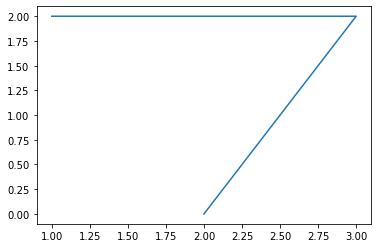

In [271]:
plt.plot(nodes[faces[1,:],0],nodes[faces[1,:],1])

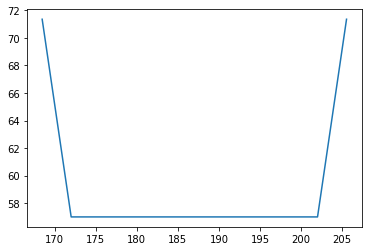

In [300]:
plt.plot(nodes[faces[59,:],0],nodes[faces[59,:],1])

In [309]:
#what tile
#we define the cap tile here:
captile=43
grid.XG.isel(i_g=[0,-1],j_g=[0,-1])
nodes3=np.stack((grid.XG.isel(i_g=[0,-1],j_g=[0,-1])[0:,:,:].values.ravel(),
                 grid.YG.isel(i_g=[0,-1],j_g=[0,-1])[0:,:,:].values.ravel()),1)

#insert additional nodes after cap node to deal with cap
to_insert=nodes3[captile*4:(captile+1)*4].copy()
to_insert[:,1]=90*np.ones(4)
#52,142
nodes3=np.insert(nodes3, captile*4+2, [nodes3[captile*4][0], 90], axis=0)
nodes3=np.insert(nodes3, captile*4+3, [nodes3[captile*4+1][0], 90], axis=0)

#52,-38
nodes3=np.insert(nodes3, captile*4+4, nodes3[captile*4], axis=0)#skip one and use the one in place
nodes3=np.insert(nodes3, captile*4+6, [nodes3[captile*4][0], 90], axis=0)
nodes3=np.insert(nodes3, captile*4+7, [nodes3[captile*4+5][0], 90], axis=0)

#-38,-128
nodes3=np.insert(nodes3, captile*4+8, nodes3[captile*4+5], axis=0)#skip one and use the one in place
nodes3=np.insert(nodes3, captile*4+10, [nodes3[captile*4+5][0], 90], axis=0)
nodes3=np.insert(nodes3, captile*4+11, [nodes3[captile*4+9][0], 90], axis=0)

#-128,142 (this one won't work, but we will fix it later)
nodes3=np.insert(nodes3, captile*4+12, nodes3[captile*4+9], axis=0)#skip one and use the one in place
nodes3=np.insert(nodes3, captile*4+13, nodes3[captile*4+1], axis=0)
nodes3=np.insert(nodes3, captile*4+14, [nodes3[captile*4+9][0], 90], axis=0)
nodes3=np.insert(nodes3, captile*4+15, [nodes3[captile*4+1][0], 90], axis=0)

col1=np.arange(0,396,4)
col2=col1+1
col3=col1+3
col4=col1+2
faces3 = np.stack((col1,col2,col3,col4),1)
faces = np.array(faces3, dtype=np.intc)
nodes = np.array(nodes3, dtype=np.float64)

#check if on dateline
for tileon in range(0,faces.shape[0]):
    xnodes=nodes[faces[tileon,:],0]
    xdist=np.diff(xnodes)
    if np.any(np.abs(xdist)>180):
        xnodes[xnodes<0]=xnodes[xnodes<0]+360
        nodes[faces[tileon,:],0]=xnodes


tree = cell_tree2d.CellTree(nodes, faces)

In [310]:
#search for point: if point is not in domain, add 360 in x-dir and try again
point = np.array([42.1, -28.9]) 
result = tree.locate(point)
if result==-1:
    point[0]=point[0]+360
    result = tree.locate(point)
    
#interpret result: cap splits one tile into four
if (result>captile) & (result<captile+4):
    result=captile
elif result>captile+3:
    result=result-3
tile=result
result

array([9], dtype=int32)

In [330]:
#where are you in the tile?
tilex=30
tiley=30
nodes3=np.stack((grid.XG[tile,:,:].values.ravel(),grid.YG[tile,:,:].values.ravel()),1)
col_base=np.arange(0,(tilex+1)*tiley)
col1=np.asarray([item for item in col_base if(item+1) % 31>0])
col2=col1+1
col3=col1+tilex+2
col4=col1+tilex+1
faces3 = np.stack((col1,col2,col3,col4),1)
nodes = np.array(nodes3, dtype=np.float64)
faces = np.array(faces3, dtype=np.intc)
tree = cell_tree2d.CellTree(nodes, faces)

In [332]:
result = tree.locate(point)
jloc=result//tilex
iloc=result-jloc*tilex
iloc

array([20], dtype=int32)

In [333]:
jloc

array([9], dtype=int32)

In [320]:
grid.YG[tile,:,:].max().values

array(-9.96973018)

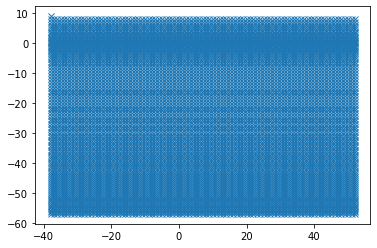

In [139]:
plt.plot(nodes[8281:8281+8100-1,0],nodes[8281:8281+8100-1,1],'x')


In [47]:
nodes3[91:93,:]

array([[-108.47212793,  -88.16335017],
       [-107.91524717,  -88.30251042]])

In [48]:
grid.XG[0,1,0:2].values

<xarray.DataArray 'XG' (face: 13, j_g: 91, i_g: 91)>
dask.array<concatenate, shape=(13, 91, 91), dtype=float64, chunksize=(1, 91, 91), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12

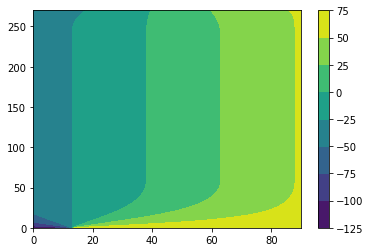

In [263]:
cs=plt.contourf(griddata.reshape(16,-1,91)[5,:,:])
plt.colorbar(cs)


In [263]:
datadir='/swot/SUM01/spencer/ECCO_singlegrid/'
griddata=np.fromfile(datadir+'YG.010.001.data','>f4')
griddata=griddata.reshape(30,30)


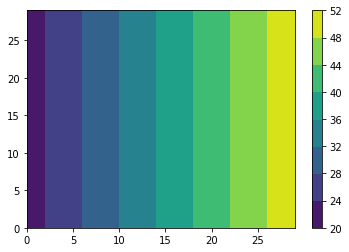

In [259]:
cs=plt.contourf(griddata)
plt.colorbar(cs)

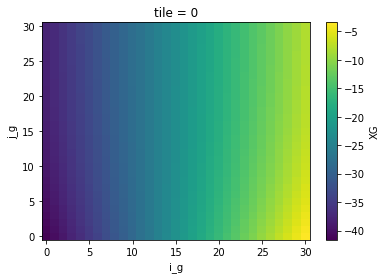

In [502]:
grid.sel(tile=0).XG.plot()

In [264]:
griddata[10,20]

-28.80116